# Simple example of Edward for BBVI
## Requires Tensorflow -- use virtualenv tf
Edward is a probabilistic programming language built on top of Tensorflow
Download from edwardlib.org

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter("ignore")
import edward as ed
import tensorflow as tf

## Generate data of size N

In [2]:
N = 4
ed.set_seed(123)
dataset = np.random.normal(loc=5, scale=1, size=N).astype(np.float32)

# DEFINE THE GENERATIVE MODEL
We will assume a model where X is Normal with unknown mu and sigma.
There are priors for mu and sigma, then we find their posteriors.
Note the syntax: A variable is defined by ed.models.SomeDistribution(parameters).
Parameters may be other variables or functions thereof. 
This is the way we (implicitly) build the DAG structure.

In [3]:
# Prior for Mu: N(0, 100**2).
# Notice that we have access to standard 
# statistical distributions, like Normal
mu = ed.models.Normal(loc=tf.zeros([1]), scale=tf.ones([1]) * 100)

# Prior for Sigma: InverseGamma(1, 1)
sigma_square = ed.models.InverseGamma(concentration=tf.ones([1]),
                                      rate=tf.ones([1]))

# Data is assumed to be generated by mean mu, Gaussian noise of scale Sigma
x = ed.models.Normal(loc=mu * tf.ones([N]),
                     scale=tf.sqrt(sigma_square))

# DEFINE VARIATIONAL MODEL
The variational model will be over the variables of interest, mu and Sigma.

The variables are named q_X to denote that they are the q-distributions
for variable X.

In [4]:
# Simple priors for the q-distributions: 
# mu is a Gaussian. 
# The parameters here are defined through trainable parameters (that are intitalized randomly)
# These play the role of lambda in the slides -- they are the ones we will optimize to get a 
# useful variational approximation to our data.
# The scale-part -- the standard deviation of the distribution -- is defined by 
# doing a softplus. That ensures the calculated std.dev. is positive, and therefore meaningful

q_mu = ed.models.Normal(loc=tf.Variable(tf.random_normal([1])),
                        scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))


# q_sigma_square is InverseGamma -- to mimic the generative model. 
# The InverseGamma has two parameters that both need to be positive. 
# We again use softplus to ensure that the positivity-constraint is kept.
q_sigma_square = ed.models.InverseGamma(concentration=tf.nn.softplus(tf.Variable(tf.random_normal([1]))),
                                        rate=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))  

# DEFINE INFERENCE AND INITIALIZE

In [5]:
# Inference is done by linking together the variables in the generative process and those in  
# the variational model. In this example mu is linked with q_mu, sigma_square with q_sigma_square. 
# <everything is bound together with the data. The x is given the observations in <dataset>.
inference_engine = ed.ScoreEntropyKLqp({mu: q_mu, sigma_square: q_sigma_square}, data={x: dataset})
inference_engine.initialize(n_iter=5000)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
learning_curve = []

# DO THE LEARNING

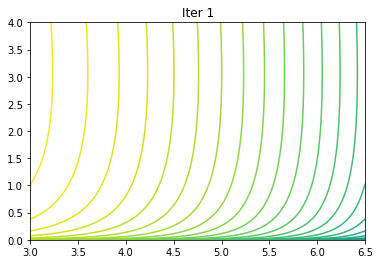



Iteration 1:
	Mu: mean=0.60, st.dev=0.83  -> 95% CI = [-1.03, 2.23]. Data mean 4.67
	SigmaSq: cons=0.94, rate=0.63 -> Mode=0.33. Data variance 1.02


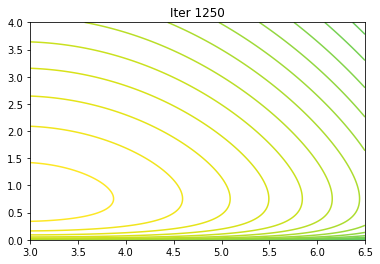



Iteration 1250:
	Mu: mean=2.88, st.dev=0.99  -> 95% CI = [0.94, 4.82]. Data mean 4.67
	SigmaSq: cons=1.00, rate=2.65 -> Mode=1.32. Data variance 1.02


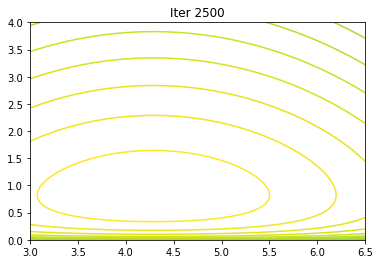



Iteration 2500:
	Mu: mean=4.29, st.dev=1.04  -> 95% CI = [2.24, 6.33]. Data mean 4.67
	SigmaSq: cons=1.21, rate=2.68 -> Mode=1.22. Data variance 1.02


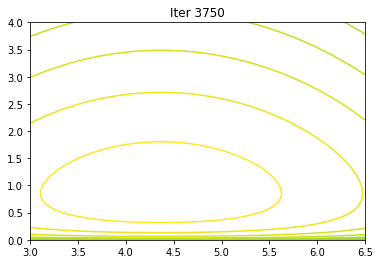



Iteration 3750:
	Mu: mean=4.37, st.dev=0.98  -> 95% CI = [2.45, 6.28]. Data mean 4.67
	SigmaSq: cons=1.29, rate=2.68 -> Mode=1.17. Data variance 1.02


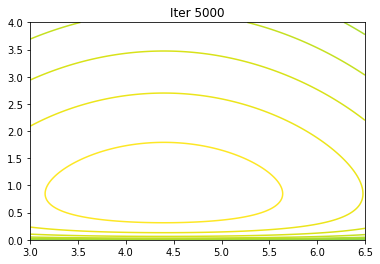



Iteration 5000:
	Mu: mean=4.40, st.dev=0.96  -> 95% CI = [2.51, 6.29]. Data mean 4.67
	SigmaSq: cons=1.27, rate=2.68 -> Mode=1.18. Data variance 1.02


In [6]:
for t in range(inference_engine.n_iter):
    info_dict = inference_engine.update()
    learning_curve.append(info_dict['loss'])

    # Do plotting and report back a few times 
    # Everything from this point onwards is not realy needed ...
    if t == 0 or (4 * (t + 1)) % inference_engine.n_iter == 0:
        mu_range = np.linspace(3, 6.5, 500).astype(np.float32)
        precision_range = np.linspace(1E-10, 4, 500).astype(np.float32)
        MU, PRECISION = np.meshgrid(mu_range, precision_range)

        Z = q_mu.log_prob(MU).eval(session=sess) + \
            q_sigma_square.log_prob(1. / PRECISION).eval(session=sess)
        plt.figure()
        plt.contour(MU, PRECISION, Z, 50)
        plt.title('Iter {:d}'.format(t + 1))
        plt.savefig('edward_iter_{:d}.png'.format(t+1), bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close('all')

        print('\n\nIteration {:d}:'.format(t + 1))
        mean_mu = q_mu.loc.eval(session=sess)[0]
        std_mu = q_mu.scale.eval(session=sess)[0]
        print('\tMu: mean={:4.2f}, st.dev={:4.2f}  -> 95% CI = [{:4.2f}, {:4.2f}]. Data mean {:4.2f}'.format(
            mean_mu,
            std_mu,
            mean_mu - 1.96 * std_mu,
            mean_mu + 1.96 * std_mu,
            np.mean(dataset)))

        sigma_cons = q_sigma_square.concentration.eval(session=sess)[0]
        sigma_rate = q_sigma_square.rate.eval(session=sess)[0]
        sigma_mode = sigma_rate / (sigma_cons + 1)
        print(
            '\tSigmaSq: cons={:4.2f}, rate={:4.2f} -> Mode={:4.2f}. Data variance {:4.2f}'.format(
                sigma_cons, sigma_rate, sigma_mode, np.square(np.std(dataset))))


## Look at ELBO per iteration -- notice high variability

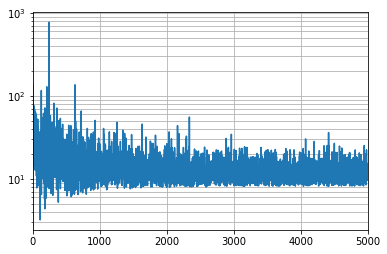

In [7]:
plt.semilogy(learning_curve)
plt.xlim(xmin=0, xmax=len(learning_curve))
plt.grid(True, which="both")
plt.savefig('edward_ELBO.png', bbox_inches='tight', pad_inches=0)
plt.show()